# Forecasting U.S. Heat in ClimPred

In [26]:
import numpy as np
import xarray as xr
import pandas as pd
import climpred
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)
climpred.set_options(warn_for_failed_PredictionEnsemble_xr_call=False)
import warnings 
warnings.filterwarnings("ignore")

from dask.distributed import Client
import dask.config
dask.config.set({"array.slicing.split_large_chunks": False})

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
client = Client("tcp://10.12.206.54:37365")

In [3]:
model = "ECMWF" # ECMWF, NCEP (only thru 2010), ECCC, CESM1, CESM2, or WACCM
data = "anom" # anom
time = "daily" # daily
var = 't2m' # t2m, tp, gh_500
region = 'WC' # CONUS, WC, MW, PL, NE, SE
metric= 'rmse' # rmse or acc
base = slice('2000-01','2010-12')
event = slice('2011-01','2011-12')

init = xr.open_zarr("/glade/work/smogen/" + model + "."+data+"."+time+".state.zarr/", consolidated=True).astype('float32')
obs = xr.open_zarr("/glade/work/smogen/OBS" + "."+data+"."+time+".state.zarr/", consolidated=True).astype('float32')

## subset the data

In [5]:
Regions= {"CONUS": [203,299,50,23] , "WC": [235,245, 50, 25 ] , "MW": [245, 255, 50, 25], "PL": [255,267, 50, 25], "NE" : [267,296, 50,37], "SE": [267,296, 37,25]}

In [6]:
init = init[var].sel(lon = slice(Regions[region][3],Regions[region][1]), lat = slice(Regions[region][2],Regions[region][3])).mean(dim=("lat","lon"))
obs = obs[var].sel(lon = slice(Regions[region][3],Regions[region][1]), lat = slice(Regions[region][2],Regions[region][3])).mean(dim=("lat","lon"))

In [7]:
%time init = init.compute()
%time obs = obs.compute()

CPU times: user 121 ms, sys: 5.01 ms, total: 126 ms
Wall time: 2.8 s
CPU times: user 26.5 ms, sys: 824 µs, total: 27.3 ms
Wall time: 305 ms


## select for base or event periods

In [8]:
obs_base = obs.sel(time=base)#.groupby('time.season').mean().sel(season = 'JJA')
init_base = init.sel(init=base)#.groupby('init.season').mean().sel(season = 'JJA')

obs_event = obs.sel(time=event)#.groupby('time.season').mean().sel(season = 'JJA')
init_event = init.sel(init=event)#.groupby('init.season').mean().sel(season = 'JJA')

In [9]:
tmp = []
slices = [slice('2000-01','2001-12'),slice('2001-01','2002-12')]
slices
for i in range(0,2):
    tmp = init.sel(init = slices[i])

## combine data

In [10]:
hind_base = climpred.HindcastEnsemble(init_base).add_observations(obs_base)
hind_event = climpred.HindcastEnsemble(init_event).add_observations(obs_event)

## Plot TS

<AxesSubplot:xlabel='time', ylabel='Daily Average Temperature\n[degC]'>

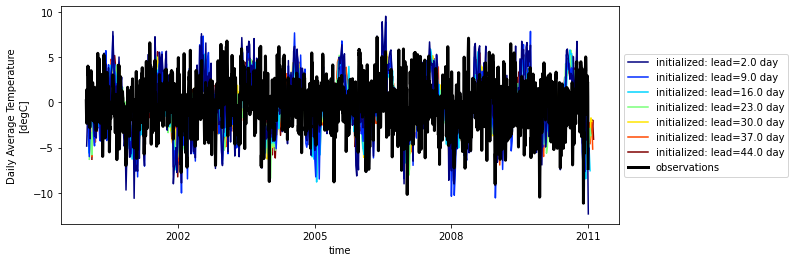

In [11]:
hind_base_tmp = hind_base.isel(lead=np.arange(1,init.lead.size,7))

# plot temporal subset # if error with kind: #!conda install pandas!=1.3.0 -c conda-forge -y
hind_base_tmp.sel(init=slice('2000','2011')).sel(time=slice('2000','2010')).plot()

<AxesSubplot:xlabel='time', ylabel='Daily Average Temperature\n[degC]'>

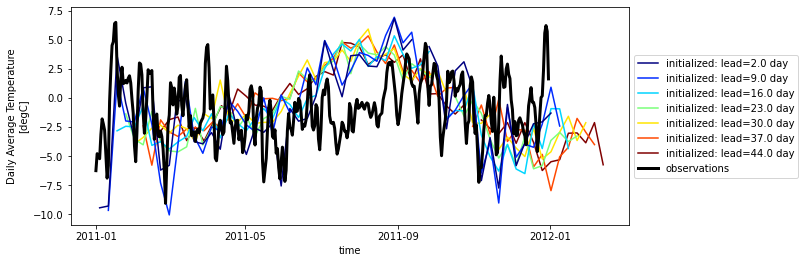

In [12]:
hind_event_tmp = hind_event.isel(lead=np.arange(1,init.lead.size,7))

# plot temporal subset # if error with kind: #!conda install pandas!=1.3.0 -c conda-forge -y
hind_event_tmp.sel(init=slice('2011','2012')).sel(time=slice('2011','2012')).plot()

## Metric

### Bias Reduction

In [13]:
verify_kwargs = dict(metric=metric, # https://climpred.readthedocs.io/en/stable/metrics.html
                    comparison='e2o', # compare ensemble member mean to observations - https://climpred.readthedocs.io/en/stable/comparisons.html
                    dim='init', # reduce this dimension, equivalent to dim in xarray
                    alignment='maximize', # https://climpred.readthedocs.io/en/stable/alignment.html
                    keep_attrs=True, skipna=True) # passed to xs.metric

In [14]:
# remove lead-time dependent bias based on monthly climatology
with climpred.set_options(seasonality='month'):
    hind_bias_reduced_base = hind_base.remove_bias('same_inits', cross_validate=False)

%time skill_bias_reduced_base = hind_bias_reduced_base.verify(**verify_kwargs)

/glade/work/berner/miniconda3/envs/s2s-asp/lib/python3.9/site-packages/climpred/bias_removal.py:138: UserWarning: HindcastEnsemble.remove_bias() is still experimental and is only tested for annual leads. Please consider contributing to https://github.com/pangeo-data/climpred/issues/605
  warnings.warn(


CPU times: user 15.2 s, sys: 16.4 ms, total: 15.3 s
Wall time: 15.5 s


In [15]:
# remove lead-time dependent bias based on monthly climatology
with climpred.set_options(seasonality='month'):
    hind_bias_reduced_event = hind_event.remove_bias('same_inits', cross_validate=False)

%time skill_bias_reduced_event = hind_bias_reduced_event.verify(**verify_kwargs)

/glade/work/berner/miniconda3/envs/s2s-asp/lib/python3.9/site-packages/climpred/bias_removal.py:138: UserWarning: HindcastEnsemble.remove_bias() is still experimental and is only tested for annual leads. Please consider contributing to https://github.com/pangeo-data/climpred/issues/605
  warnings.warn(


CPU times: user 438 ms, sys: 1.02 ms, total: 439 ms
Wall time: 445 ms


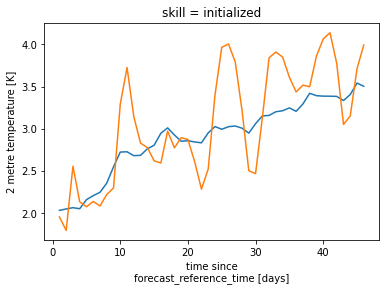

In [16]:
skill_bias_reduced_base.t2m.plot(label='ACC after bias reduction')
skill_bias_reduced_event.t2m.plot(label='ACC after bias reduction')

### Perfect Model

In [17]:
pm = climpred.PerfectModelEnsemble(hind_base.get_initialized())

verify_kwargs_pm = dict(metric=metric,
                        comparison='m2e',  # compare each member to ensemble mean forecast
                        dim=['init','member'], # reduce dims
                        keep_attrs=True, skipna=True)

pm_skill_base = pm.verify(**verify_kwargs_pm)
# perfectModel skill is often best

In [18]:
pm = climpred.PerfectModelEnsemble(hind_event.get_initialized())

verify_kwargs_pm = dict(metric=metric,
                        comparison='m2e',  # compare each member to ensemble mean forecast
                        dim=['init','member'], # reduce dims
                        keep_attrs=True, skipna=True)

pm_skill_event = pm.verify(**verify_kwargs_pm)
# perfectModel skill is often best

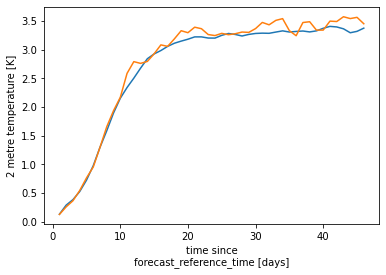

In [19]:
pm_skill_base.t2m.plot(label='PerfectModel ACC')
pm_skill_event.t2m.plot(label='PerfectModel ACC')

### Reference forecast

In [20]:
skill_reference_base = hind_bias_reduced_base.verify(reference=['persistence','climatology'], **verify_kwargs)
skill_reference_event = hind_bias_reduced_event.verify(reference=['persistence','climatology'], **verify_kwargs)

### plot them all

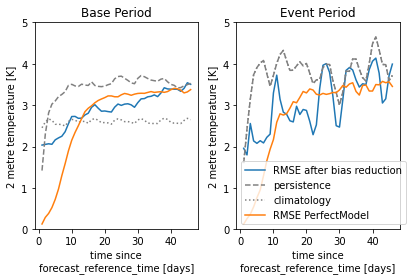

In [24]:
f, ax = plt.subplots(1,2)

skill_bias_reduced_base.t2m.plot(ax = ax[0], label=f'{metric.upper()} after bias reduction')
skill_reference_base.sel(skill='persistence').t2m.plot(ax = ax[0], c='gray',ls='--',label='persistence')
skill_reference_base.sel(skill='climatology').t2m.plot(ax = ax[0], c='gray',ls=':',label='climatology')
pm_skill_base.t2m.plot(ax = ax[0], label=f'{metric.upper()} PerfectModel')
ax[0].set_title('Base Period')
ax[0].set_ylim(0,5)

skill_bias_reduced_event.t2m.plot(ax = ax[1], label=f'{metric.upper()} after bias reduction')
skill_reference_event.sel(skill='persistence').t2m.plot(ax = ax[1], c='gray',ls='--',label='persistence')
skill_reference_event.sel(skill='climatology').t2m.plot(ax = ax[1], c='gray',ls=':',label='climatology')
pm_skill_event.t2m.plot(ax = ax[1], label=f'{metric.upper()} PerfectModel')
ax[1].set_title('Event Period')
ax[1].set_ylim(0,5)
ax[1].legend()

plt.tight_layout()
# plt.legend(bbox_to_anchor=(1.05, 1))
# plt.title(f'{metric.upper()} for {region} by forecast model {model} biweekly averaged')

### Plot Bias reduction and perfect model for all years

CPU times: user 445 ms, sys: 1.01 ms, total: 446 ms
Wall time: 454 ms
CPU times: user 450 ms, sys: 978 µs, total: 451 ms
Wall time: 459 ms
CPU times: user 452 ms, sys: 10 µs, total: 452 ms
Wall time: 463 ms
CPU times: user 441 ms, sys: 969 µs, total: 441 ms
Wall time: 471 ms
CPU times: user 551 ms, sys: 13.9 ms, total: 565 ms
Wall time: 575 ms
CPU times: user 440 ms, sys: 968 µs, total: 441 ms
Wall time: 450 ms
CPU times: user 437 ms, sys: 0 ns, total: 437 ms
Wall time: 446 ms
CPU times: user 436 ms, sys: 992 µs, total: 437 ms
Wall time: 446 ms
CPU times: user 437 ms, sys: 993 µs, total: 438 ms
Wall time: 445 ms
CPU times: user 436 ms, sys: 1.98 ms, total: 438 ms
Wall time: 444 ms
CPU times: user 438 ms, sys: 998 µs, total: 439 ms
Wall time: 450 ms


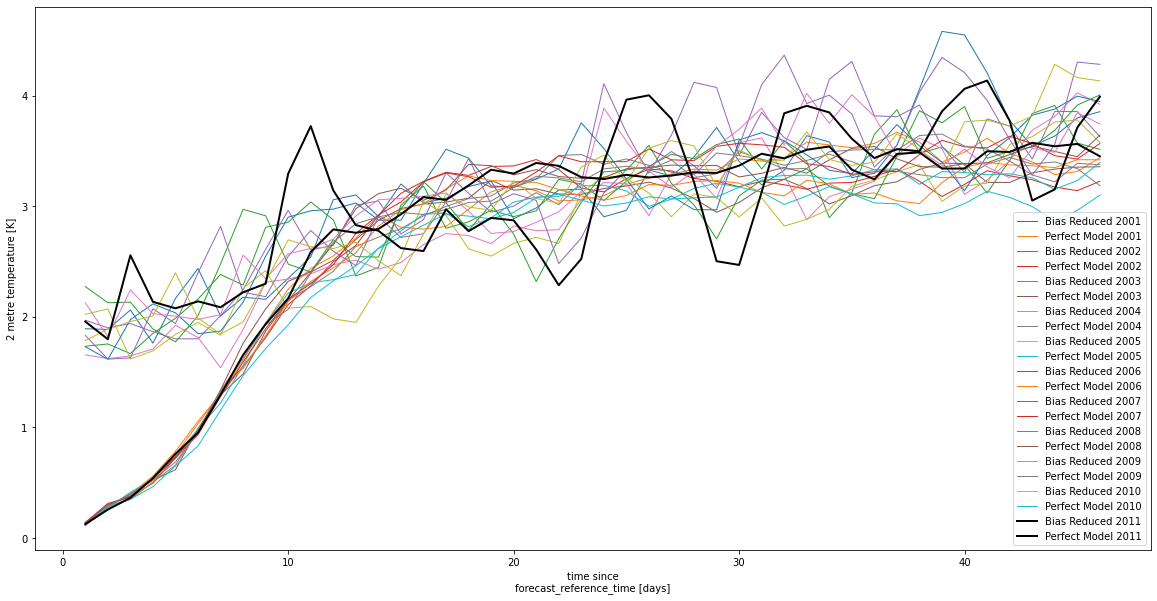

In [27]:
# run for seasonal values

years = ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011']

for i in range (0,11):
    obs_summer = obs.sel(time = years[i])#.groupby('time.month').mean().sel(month = slice(6,8))
# obs_summer['month'] = pd.date_range(years[0] + '-06',years[0] + '-08',freq='MS')
# obs_summer = obs_summer.rename({'month':'time'})

    init_summer = init.sel(init = years[i])#.groupby('init.month').mean().sel(month = slice(6,8))
# init_summer['month'] = pd.date_range(years[0] + '-06',years[0] + '-08',freq='MS')
# init_summer = init_summer.rename({'month':'init'})

    hind = climpred.HindcastEnsemble(init_summer).add_observations(obs_summer)

    # Bias Reduction!
    verify_kwargs = dict(metric=metric, # https://climpred.readthedocs.io/en/stable/metrics.html
                    comparison='e2o', # compare ensemble member mean to observations - https://climpred.readthedocs.io/en/stable/comparisons.html
                    dim='init', # reduce this dimension, equivalent to dim in xarray
                    alignment='maximize', # https://climpred.readthedocs.io/en/stable/alignment.html
                    keep_attrs=True, skipna=True) # passed to xs.metric

    with climpred.set_options(seasonality='month'):
        hind_bias_reduced = hind.remove_bias('same_inits', cross_validate=False) 

    %time skill_bias_reduced = hind_bias_reduced.verify(**verify_kwargs)
    plt.rcParams["figure.figsize"] = (20,10)

    if i == 10:
        skill_bias_reduced.t2m.plot(label = 'Bias Reduced ' + years[i], lw=2,color='k')
    else: 
        skill_bias_reduced.t2m.plot(label = 'Bias Reduced ' + years[i], lw=1)
    plt.legend(loc = 'best')

    # Perfect Model!
    pm = climpred.PerfectModelEnsemble(hind.sel(init = years[i]).get_initialized())
    verify_kwargs_pm = dict(metric=metric,
                        comparison='m2e',  # compare each member to ensemble mean forecast
                        dim=['init','member'], # reduce dims
                        keep_attrs=True, skipna=True)
    pm_skill_base = pm.verify(**verify_kwargs_pm)
    if i == 10:
        pm_skill_base.t2m.plot(label = 'Perfect Model ' + years[i], lw=2,color='k')
    else: 
        pm_skill_base.t2m.plot(label = 'Perfect Model ' + years[i], lw=1)
    plt.legend(loc = 'best')
    
#     init_group = 'season' # month # dayofyear
#     skill_group = []
#     label_group = []
#     for group, hind_group in hind_bias_reduced.get_initialized().init.groupby(f'init.{init_group}'):
#         skill_group.append(hind_bias_reduced.sel(init=hind_group).verify(**verify_kwargs))
#         label_group.append(group)
#     skill_group = xr.concat(skill_group, init_group).assign_coords({init_group:label_group})

#     skill_group.t2m.plot()

## Init time-dependent skill

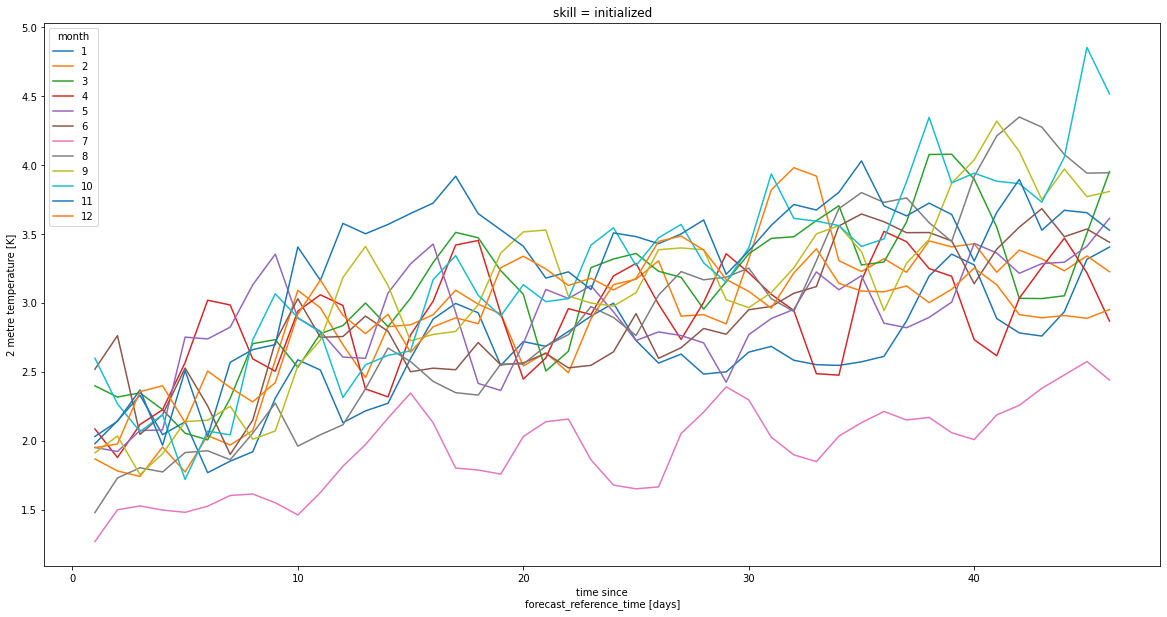

In [30]:
init_group = 'month' # month # dayofyear
skill_group = []
label_group = []
for group, hind_group in hind_bias_reduced_base.get_initialized().init.groupby(f'init.{init_group}'):
    skill_group.append(hind_bias_reduced_base.sel(init=hind_group).verify(**verify_kwargs))
    label_group.append(group)
skill_group_base = xr.concat(skill_group, init_group).assign_coords({init_group:label_group})

skill_group_base.t2m.plot(hue=init_group)

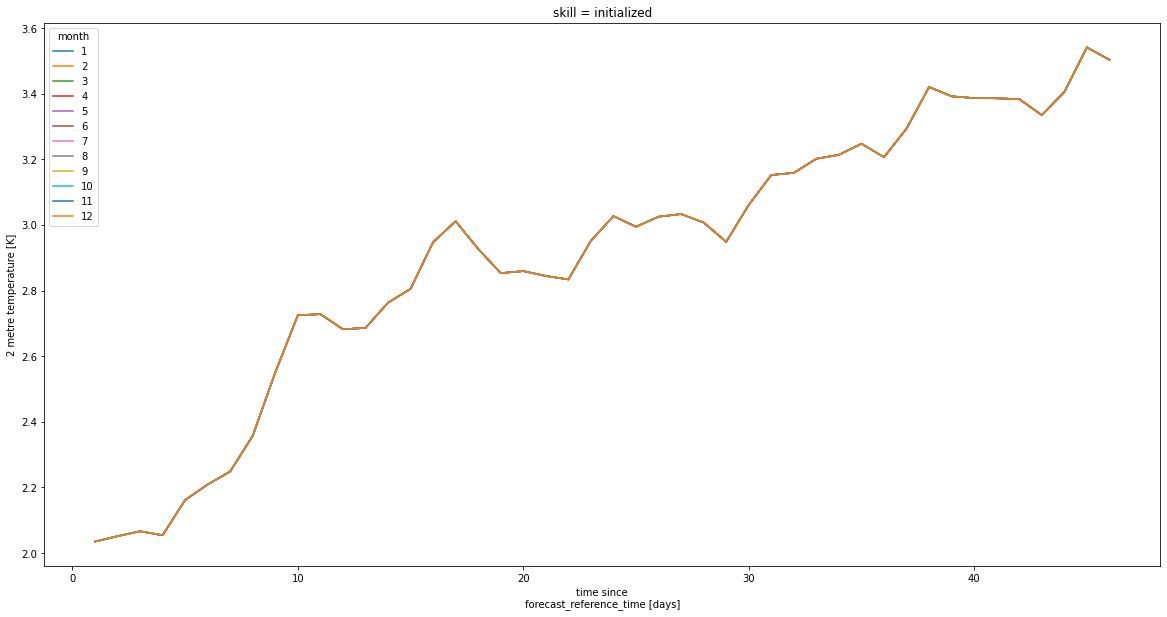

In [31]:
init_group = 'month' # month # dayofyear
skill_group = []
label_group = []
for group, hind_group in hind_bias_reduced_event.get_initialized().init.groupby(f'init.{init_group}'):
    skill_group.append(hind_bias_reduced_base.sel(init=hind_group).verify(**verify_kwargs))
    label_group.append(group)
skill_group_event = xr.concat(skill_group, init_group).assign_coords({init_group:label_group})

skill_group_event.t2m.plot(hue=init_group)

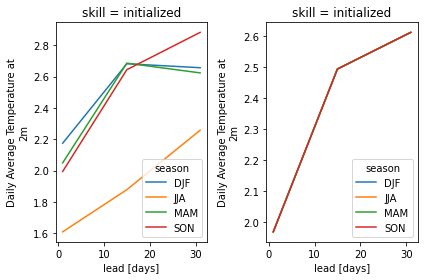

In [46]:
f, ax = plt.subplots(1,2)

skill_group_base.t2m.plot(ax = ax[0], hue=init_group)
skill_group_event.t2m.plot(ax = ax[1], hue=init_group)
plt.tight_layout()

# obs plotting

In [200]:
init = xr.open_zarr("/glade/work/smogen/" + model + "."+data+"."+time+".state.zarr/", consolidated=True).astype('float32')
obs = xr.open_zarr("/glade/work/smogen/OBS" + "."+data+"."+time+".state.zarr/", consolidated=True).astype('float32')

In [205]:
obs_season = obs.t2m.sel(time=slice('2011-01','2011-12')).groupby('time.season').mean()
obs_base = obs.t2m.sel(time=slice('2000-01','2010-12')).groupby('time.season').mean()

In [206]:
summer = obs_season.sel(season='JJA').compute() - obs_base.sel(season='JJA').compute()

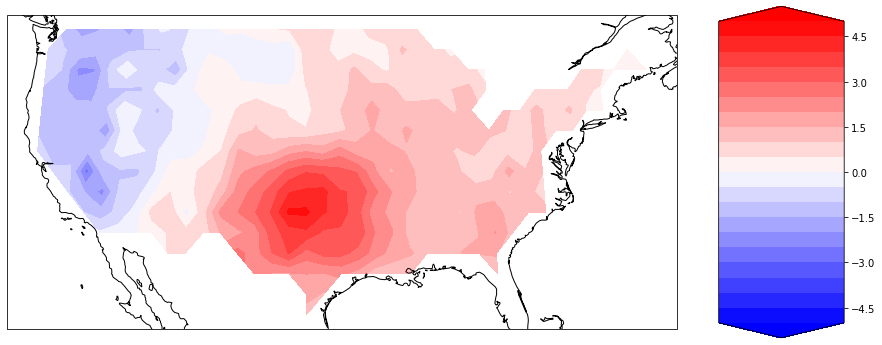

In [209]:
f, axs = plt.subplots(nrows=1,ncols=1,figsize=(15,15),
                      subplot_kw=dict(projection=ccrs.Robinson(central_longitude=260)))

im = axs.contourf(summer.lon,summer.lat,summer,transform = ccrs.PlateCarree(),
            cmap = 'bwr',levels=np.arange(-5,5.1,0.5),extend='both')

axs.coastlines(color='k')

f.colorbar(im,aspect=2.4)